In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp "/content/gdrive/MyDrive/UTKFace.tar.gz" .

In [3]:
!tar -xzf UTKFace.tar.gz

In [4]:
def find_label(image_addr):
  splited_addr = image_addr.split('_')
  if len(splited_addr) != 4: return -1
  race = splited_addr[2]
  return race

Reading data from directory and removing the dump data

In [5]:
import glob
images = glob.glob("/content/UTKFace" + "/*.jpg")
races = []
dump_images = []

for img in images:
  z = find_label(img)
  if z == -1:
    dump_images.append(img)
  else:
    races.append(z)

for img in dump_images:
  images.remove(img)

creating a pandas data frame with columns images and races

In [6]:
import pandas as pd
oneHot_races = []
for race in races:
  temp = ['0'] * 5
  temp[int(race)] = '1'
  oneHot_races.append("".join(temp))

data_tuples = list(zip(images,races))
data_tuples
train_data = pd.DataFrame(data_tuples, columns=['Image','Race'])
train_data

,Image,Race
0,/content/UTKFace/65_0_1_20170120223029947.jpg....,1
1,/content/UTKFace/13_1_0_20170109214314841.jpg....,0
2,/content/UTKFace/30_1_4_20170109135421119.jpg....,4
3,/content/UTKFace/70_0_2_20170116192621613.jpg....,2
4,/content/UTKFace/7_1_3_20161220222033539.jpg.c...,3
...,...,...
23700,/content/UTKFace/26_0_1_20170117195838909.jpg....,1
23701,/content/UTKFace/16_0_0_20170110232332618.jpg....,0
23702,/content/UTKFace/1_0_1_20170110213647161.jpg.c...,1
23703,/content/UTKFace/56_1_0_20170110122842545.jpg....,0


Finding out the specific number of instances for each label (race) and comparing them using plots

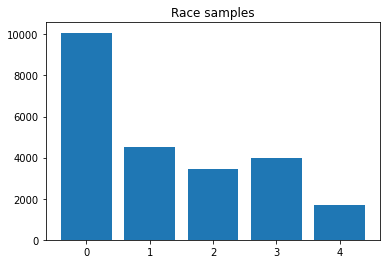

In [ ]:
race_types = [0] * 5
for i in races:
  race_types[int(i)] += 1

import matplotlib.pyplot as plt
plt.bar(range(len(race_types)), race_types)
plt.title('Race samples')
plt.show()

showing an instance image for each race

race  1 :


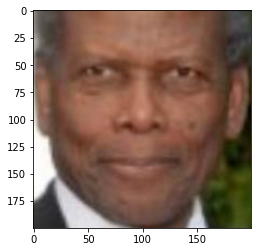

race  0 :


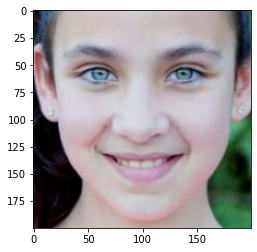

race  4 :


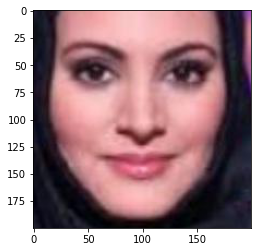

race  2 :


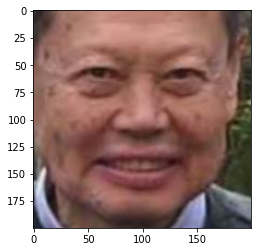

race  3 :


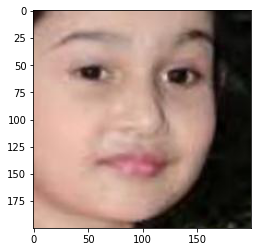

In [ ]:
from keras.preprocessing.image import image

seen_races = []

for i in range(len(images)):
  if len(seen_races) == 5: break
  if races[i] not in seen_races:
    seen_races.append(races[i])
    print('race ',races[i],':')
    img = image.load_img(images[i])
    img = image.img_to_array(img)
    plt.imshow(img/255) 
    plt.show()

changing the lables to oneHot form and seperating data set into train and test 

In [7]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def generator(train_data, rescale = False, shuffle = True):
  train_data = train_data.assign(Race=oneHot_races)
  if rescale == False:
    imageGen = ImageDataGenerator(validation_split=0.2)
  else:
    imageGen = ImageDataGenerator(rescale = 1. / 255, validation_split=0.2)

  train_generator=imageGen.flow_from_dataframe(
  dataframe=train_data,
  x_col="Image",
  y_col="Race",
  subset="training",
  color_mode = "grayscale",
  batch_size=32,
  seed=42,
  shuffle=shuffle,
  class_mode="categorical",
  target_size=(100,100))


  test_generator=imageGen.flow_from_dataframe(
  dataframe=train_data,
  x_col="Image",
  y_col="Race",
  subset="validation",
  color_mode = "grayscale",
  batch_size=32,
  seed=42,
  shuffle=shuffle,
  class_mode="categorical",
  target_size=(100,100))

  return train_generator, test_generator

train_generator, test_generator = generator(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.


In [8]:
from tensorflow.keras import *
inp = layers.Input(shape=(100,100,1))
Flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(Flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 321,253
Trainable params: 321,253
Non-trainable params: 0
_________________________________________________________________


The param is equal to total weights in that layer plus the bias values

In [ ]:
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=10)

Epoch 1/10
593/593 [==============================] - 26s 43ms/step - loss: 9601892352.0000 - accuracy: 0.4230 - val_loss: 1.4619 - val_accuracy: 0.4244
Epoch 2/10
593/593 [==============================] - 26s 44ms/step - loss: 1.4536 - accuracy: 0.4253 - val_loss: 1.4520 - val_accuracy: 0.4244
Epoch 3/10
593/593 [==============================] - 25s 43ms/step - loss: 1.4489 - accuracy: 0.4253 - val_loss: 1.4502 - val_accuracy: 0.4244
Epoch 4/10
593/593 [==============================] - 25s 43ms/step - loss: 1.4477 - accuracy: 0.4253 - val_loss: 1.4497 - val_accuracy: 0.4244
Epoch 5/10
593/593 [==============================] - 25s 43ms/step - loss: 1.4473 - accuracy: 0.4253 - val_loss: 1.4495 - val_accuracy: 0.4244
Epoch 6/10
593/593 [==============================] - 25s 43ms/step - loss: 1.4472 - accuracy: 0.4253 - val_loss: 1.4495 - val_accuracy: 0.4244
Epoch 7/10
593/593 [==============================] - 25s 43ms/step - loss: 1.4471 - accuracy: 0.4253 - val_loss: 1.4495 - val_

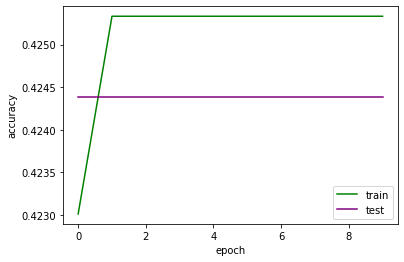

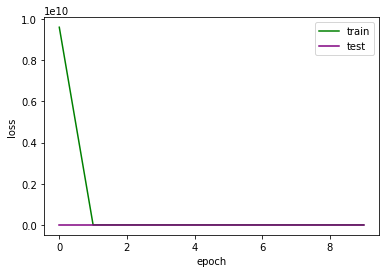

In [ ]:
def show_train_test_plot(feature, keras_model):
  plt.plot(keras_model.history[feature], color = 'green')
  plt.plot(keras_model.history['val_' + feature], color="purple")
  plt.xlabel('epoch')
  plt.ylabel(feature)
  plt.legend(['train', 'test'])
  plt.show()

def show_plot(keras_model):
  show_train_test_plot('accuracy', keras_model)
  show_train_test_plot('loss', keras_model)
 
show_plot(fitted_model)

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

def get_predicted_class(arr):
  ans = []
  for predictions in arr:
    Max = max(predictions)
    index = np.argmax(predictions)
    ans.append(index)
  return ans

def show_acc_Recal_precision_macroF1(y_pred, y_actual):
  s = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_actual[i]:
      s += 1
  print("accuracy: ",s/len(y_pred))
  y_true = np.array(y_actual)
  y_pred = np.array(y_pred)
  print("Recal                  precision             macro F1")
  print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

def show_accuracy(train_data, rscale = True):
  train_generator, test_generator = generator(train_data, rescale = rscale, shuffle = False)
  print("Train:")
  yTrain = model.predict(train_generator)
  y_pred = get_predicted_class(yTrain)
  y_actual = train_generator.classes
  show_acc_Recal_precision_macroF1(y_pred, y_actual)
  
  print("\nTest:")
  yTest = model.predict(test_generator)
  y_pred = get_predicted_class(yTest)
  y_actual = test_generator.classes
  show_acc_Recal_precision_macroF1(y_pred, y_actual)


In [ ]:
  show_accuracy(train_data, rscale = False)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.4253322083948534
Recal                  precision             macro F1
(0.08506644167897068, 0.2, 0.11936366999630041, None)

Test:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.42438304155241513
Recal                  precision             macro F1
(0.08487660831048302, 0.2, 0.11917666222419668, None)


**Phase 3**

Normalizing data

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.


In [ ]:
inp = layers.Input(shape=(100,100,1))
Flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(Flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=10)

Epoch 1/10
593/593 [==============================] - 26s 43ms/step - loss: 1.3402 - accuracy: 0.4697 - val_loss: 1.1749 - val_accuracy: 0.5564
Epoch 2/10
593/593 [==============================] - 26s 43ms/step - loss: 1.1642 - accuracy: 0.5611 - val_loss: 1.0877 - val_accuracy: 0.5862
Epoch 3/10
593/593 [==============================] - 25s 43ms/step - loss: 1.0704 - accuracy: 0.6024 - val_loss: 0.9952 - val_accuracy: 0.6248
Epoch 4/10
593/593 [==============================] - 26s 44ms/step - loss: 1.0139 - accuracy: 0.6317 - val_loss: 0.9433 - val_accuracy: 0.6503
Epoch 5/10
593/593 [==============================] - 26s 43ms/step - loss: 0.9661 - accuracy: 0.6480 - val_loss: 0.9592 - val_accuracy: 0.6343
Epoch 6/10
593/593 [==============================] - 26s 43ms/step - loss: 0.9399 - accuracy: 0.6641 - val_loss: 0.9339 - val_accuracy: 0.6591
Epoch 7/10
593/593 [==============================] - 26s 43ms/step - loss: 0.9256 - accuracy: 0.6647 - val_loss: 0.9169 - val_accuracy:

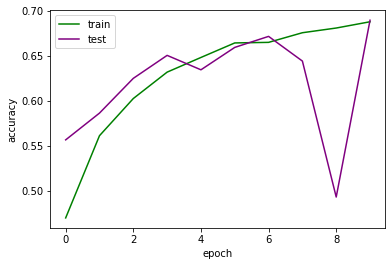

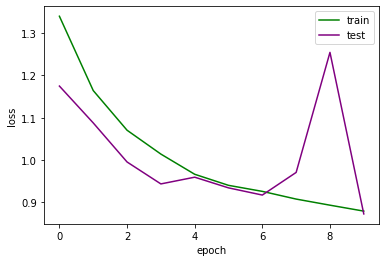

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.6931027209449483
Recal                  precision             macro F1
(0.6226876088453143, 0.5734366081603903, 0.5608730011366785, None)

Test:
accuracy:  0.6893060535751951
Recal                  precision             macro F1
(0.5733687260940629, 0.5753265273481453, 0.5607883409439041, None)


**Part1** (changing optimizer)

The momentum factor is a coefficient that is applied to an extra term in the weights update.

Advantages:

Beside others, momentum is known to speed up learning and to help not getting stuck in local minima.

with momentum The weighting of previous time steps drops off exponentially so the most recent time step has the greatest impact

momentum = 0.5

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum = 0.5), loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=10)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Epoch 1/10
593/593 [==============================] - 27s 44ms/step - loss: 1.2972 - accuracy: 0.4985 - val_loss: 1.2361 - val_accuracy: 0.5161
Epoch 2/10
593/593 [==============================] - 26s 44ms/step - loss: 1.0895 - accuracy: 0.5938 - val_loss: 0.9540 - val_accuracy: 0.6549
Epoch 3/10
593/593 [==============================] - 26s 44ms/step - loss: 1.0064 - accuracy: 0.6335 - val_loss: 1.0121 - val_accuracy: 0.6250
Epoch 4/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9584 - accuracy: 0.6522 - val_loss: 0.9368 - val_accuracy: 0.6716
Epoch 5/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9354 - accuracy: 0.6651 - val_loss: 0.8978 - val_accuracy: 0.6864
Epoch 6/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9071 - accuracy: 0.6752 - val_loss: 0.9794 - val_accuracy: 0.6499
Epoch 7/10
59

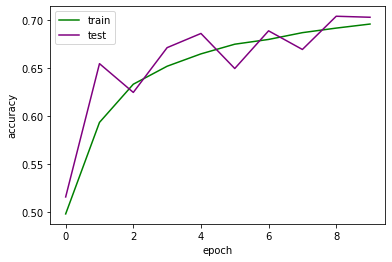

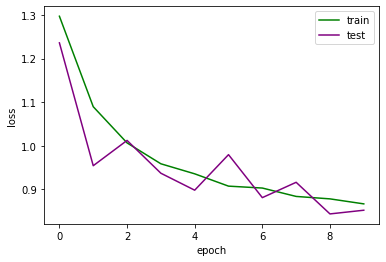

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.7118224003374816
Recal                  precision             macro F1
(0.5765227938914632, 0.6012855880552801, 0.5821099973181718, None)

Test:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.7032271672642902
Recal                  precision             macro F1
(0.5654476897334985, 0.5966432412580672, 0.5744608919950268, None)


momentum = 0.9

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum = 0.9), loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=10)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 165       
Total params: 321,253
Trainable params: 321,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
593/593 [==============================] - 26s 44ms/step - loss: 1.3894 - accuracy: 0.4505 - val_loss: 1.45

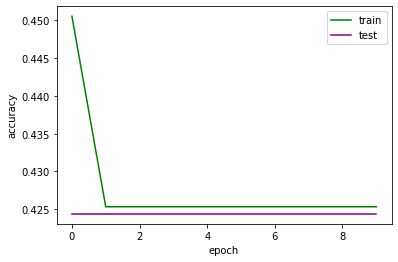

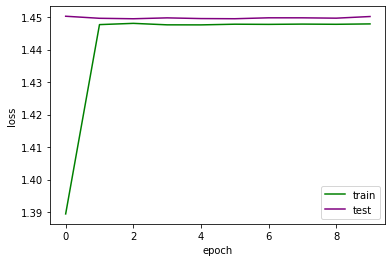

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.4253322083948534
Recal                  precision             macro F1
(0.08506644167897068, 0.2, 0.11936366999630041, None)

Test:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.42438304155241513
Recal                  precision             macro F1
(0.08487660831048302, 0.2, 0.11917666222419668, None)


Adam optimizer

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=10)

Epoch 1/10
593/593 [==============================] - 27s 45ms/step - loss: 1.2577 - accuracy: 0.5271 - val_loss: 1.0755 - val_accuracy: 0.6111
Epoch 2/10
593/593 [==============================] - 26s 44ms/step - loss: 1.0391 - accuracy: 0.6281 - val_loss: 0.9283 - val_accuracy: 0.6798
Epoch 3/10
593/593 [==============================] - 26s 45ms/step - loss: 0.9618 - accuracy: 0.6578 - val_loss: 0.9255 - val_accuracy: 0.6785
Epoch 4/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9285 - accuracy: 0.6674 - val_loss: 0.8968 - val_accuracy: 0.6832
Epoch 5/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9213 - accuracy: 0.6762 - val_loss: 0.8662 - val_accuracy: 0.6897
Epoch 6/10
593/593 [==============================] - 26s 44ms/step - loss: 0.8917 - accuracy: 0.6857 - val_loss: 0.9145 - val_accuracy: 0.6804
Epoch 7/10
593/593 [==============================] - 26s 44ms/step - loss: 0.8805 - accuracy: 0.6888 - val_loss: 0.9837 - val_accuracy:

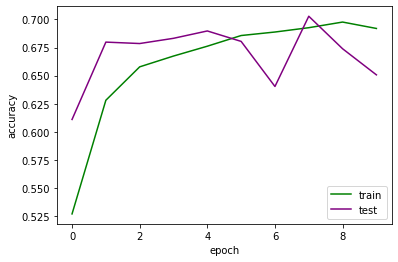

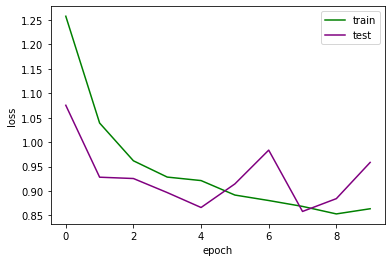

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.6598818814596077
Recal                  precision             macro F1
(0.6575529748441665, 0.4926701608766271, 0.5188479955041906, None)

Test:
accuracy:  0.650706601982704
Recal                  precision             macro F1
(0.5835352891701924, 0.486631374541264, 0.5078315606524344, None)


**part2** (changing epochs)

By training data in multiple epochs, as we see we can get a higher accuracy until overfitting has not happened.

in some cases if the first result(first epoch) is good enough for us, we may not need to train our data in multiple *epochs*

It is not always good to train data in many epochs because after a while we reach the mazimum accuracy and the accuracy starts to decrease in the following epochs and that is because of overfitting problem.

epochs = 20

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=20)

Epoch 1/20
593/593 [==============================] - 26s 44ms/step - loss: 1.2587 - accuracy: 0.5185 - val_loss: 1.0577 - val_accuracy: 0.6243
Epoch 2/20
593/593 [==============================] - 26s 44ms/step - loss: 1.0523 - accuracy: 0.6189 - val_loss: 1.0255 - val_accuracy: 0.6250
Epoch 3/20
593/593 [==============================] - 26s 44ms/step - loss: 0.9664 - accuracy: 0.6556 - val_loss: 0.9747 - val_accuracy: 0.6507
Epoch 4/20
593/593 [==============================] - 26s 44ms/step - loss: 0.9344 - accuracy: 0.6682 - val_loss: 0.9386 - val_accuracy: 0.6785
Epoch 5/20
593/593 [==============================] - 26s 44ms/step - loss: 0.9075 - accuracy: 0.6773 - val_loss: 0.8869 - val_accuracy: 0.6809
Epoch 6/20
593/593 [==============================] - 26s 44ms/step - loss: 0.8882 - accuracy: 0.6874 - val_loss: 0.9397 - val_accuracy: 0.6589
Epoch 7/20
593/593 [==============================] - 26s 44ms/step - loss: 0.8686 - accuracy: 0.6933 - val_loss: 0.8388 - val_accuracy:

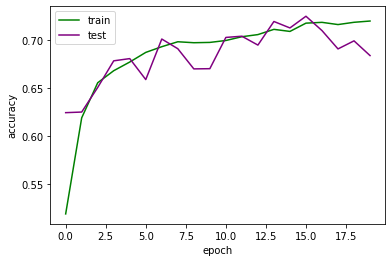

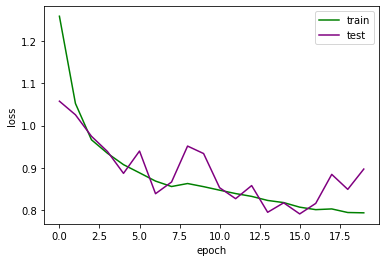

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.7017506855093862
Recal                  precision             macro F1
(0.7360261475087011, 0.5773569088168914, 0.5659006724245159, None)

Test:
accuracy:  0.6840329044505379
Recal                  precision             macro F1
(0.5889663220374587, 0.5619224293179798, 0.5448140922254697, None)


**Part3**(changing the loss function)

loss function = MSE

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(flatten_inp)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer='adam', loss="MSE", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=20)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Epoch 1/20
593/593 [==============================] - 27s 44ms/step - loss: 0.3046 - accuracy: 0.2345 - val_loss: 0.3232 - val_accuracy: 0.1919
Epoch 2/20
593/593 [==============================] - 26s 44ms/step - loss: 0.3237 - accuracy: 0.1907 - val_loss: 0.3232 - val_accuracy: 0.1919
Epoch 3/20
593/593 [==============================] - 26s 44ms/step - loss: 0.3237 - accuracy: 0.1907 - val_loss: 0.3232 - val_accuracy: 0.1919
Epoch 4/20
593/593 [==============================] - 26s 44ms/step - loss: 0.3237 - accuracy: 0.1907 - val_loss: 0.3232 - val_accuracy: 0.1919
Epoch 5/20
593/593 [==============================] - 26s 44ms/step - loss: 0.3237 - accuracy: 0.1907 - val_loss: 0.3232 - val_accuracy: 0.1919
Epoch 6/20
593/593 [==============================] - 26s 44ms/step - loss: 0.3237 - accuracy: 0.1907 - val_loss: 0.3232 - val_accuracy: 0.1919
Epoch 7/20
59

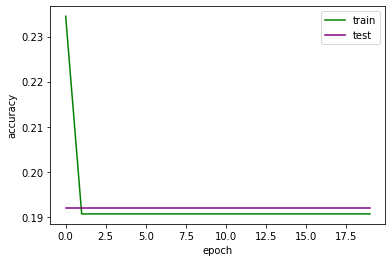

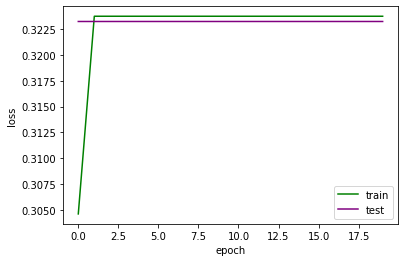

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.190677072347606
Recal                  precision             macro F1
(0.0381354144695212, 0.2, 0.06405668733392382, None)

Test:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.19194262813752372
Recal                  precision             macro F1
(0.03838852562750474, 0.2, 0.06441337816315695, None)


As we see the result is not good when using MSE as loss function. loss value is constant and the weights are not being updated.

When to use MSE as loss function?
when we do not need Outliers to be handled properly. As outlier error will be quite large, it is penalized squaring it.

**Part4**(changing regularization)

Regularization is a form of regression, that constrains/ regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2=0.0001))(flatten_inp)
Layer2_out = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2=0.0001))(Layer1_out)
Neural_out = layers.Dense(5, activation="softmax", kernel_regularizer=regularizers.l2(l2=0.0001))(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=20)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Epoch 1/20
593/593 [==============================] - 27s 46ms/step - loss: 1.2822 - accuracy: 0.5172 - val_loss: 1.1066 - val_accuracy: 0.5897
Epoch 2/20
593/593 [==============================] - 27s 45ms/step - loss: 1.0800 - accuracy: 0.6049 - val_loss: 0.9912 - val_accuracy: 0.6359
Epoch 3/20
593/593 [==============================] - 27s 45ms/step - loss: 0.9857 - accuracy: 0.6455 - val_loss: 0.9028 - val_accuracy: 0.6739
Epoch 4/20
593/593 [==============================] - 27s 45ms/step - loss: 0.9521 - accuracy: 0.6653 - val_loss: 0.9300 - val_accuracy: 0.6642
Epoch 5/20
593/593 [==============================] - 27s 45ms/step - loss: 0.9289 - accuracy: 0.6705 - val_loss: 0.9613 - val_accuracy: 0.6543
Epoch 6/20
593/593 [==============================] - 27s 45ms/step - loss: 0.9105 - accuracy: 0.6793 - val_loss: 0.8896 - val_accuracy: 0.6931
Epoch 7/20
59

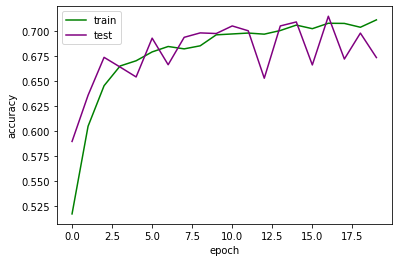

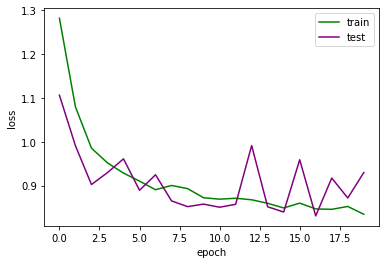

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.6849293398017295
Recal                  precision             macro F1
(0.6398435134975988, 0.5232741847142017, 0.543242672162548, None)

Test:
accuracy:  0.6736975321662096
Recal                  precision             macro F1
(0.613884340544165, 0.5137813726680767, 0.5287078561021044, None)


dropout = 0.1

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

In [ ]:
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(32, activation="relu")(flatten_inp)
Layer1_out = layers.Dropout(0.1)(Layer1_out)
Layer2_out = layers.Dense(32, activation="relu")(Layer1_out)
Layer2_out = layers.Dropout(0.1)(Layer2_out)
Neural_out = layers.Dense(5, activation="softmax")(Layer2_out)

model = models.Model(inputs=inp, outputs=Neural_out)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
fitted_model = model.fit(train_generator, validation_data = test_generator ,epochs=20)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Epoch 1/20
593/593 [==============================] - 27s 44ms/step - loss: 1.4445 - accuracy: 0.4140 - val_loss: 1.4670 - val_accuracy: 0.4244
Epoch 2/20
593/593 [==============================] - 26s 44ms/step - loss: 1.4517 - accuracy: 0.4253 - val_loss: 1.4498 - val_accuracy: 0.4244
Epoch 3/20
593/593 [==============================] - 26s 44ms/step - loss: 1.4495 - accuracy: 0.4253 - val_loss: 1.4496 - val_accuracy: 0.4244
Epoch 4/20
593/593 [==============================] - 26s 44ms/step - loss: 1.4483 - accuracy: 0.4253 - val_loss: 1.4499 - val_accuracy: 0.4244
Epoch 5/20
593/593 [==============================] - 26s 44ms/step - loss: 1.4481 - accuracy: 0.4253 - val_loss: 1.4496 - val_accuracy: 0.4244
Epoch 6/20
593/593 [==============================] - 26s 44ms/step - loss: 1.4487 - accuracy: 0.4253 - val_loss: 1.4495 - val_accuracy: 0.4244
Epoch 7/20
59

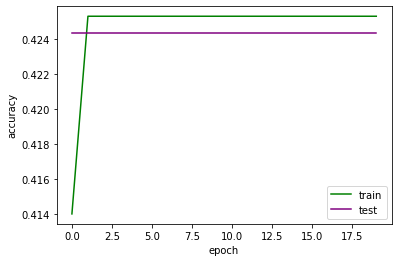

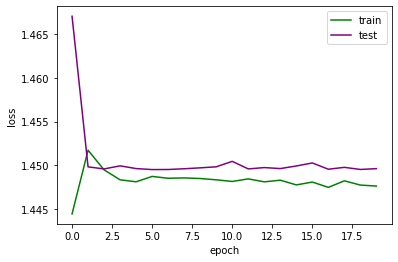

In [ ]:
show_plot(fitted_model)

In [ ]:
 show_accuracy(train_data)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Train:
accuracy:  0.4253322083948534
Recal                  precision             macro F1
(0.08506644167897068, 0.2, 0.11936366999630041, None)

Test:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.42438304155241513
Recal                  precision             macro F1
(0.08487660831048302, 0.2, 0.11917666222419668, None)


In [ ]:
train_generator, test_generator = generator(train_data, shuffle = False)
yTrain = model.predict(train_generator)
y_pred = get_predicted_class(yTrain)
y_actual = train_generator.classes

wrong = []
right = []

for i in range(len(y_pred)):
  if i == 21:
    break
  if y_pred[i] == y_actual[i]:
    if len(right) < 10:
      right.append(train_generator.filenames[i])
  else:
    if len(wrong) < 10:
      wrong.append(train_generator.filenames[i])

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.


true predictions:


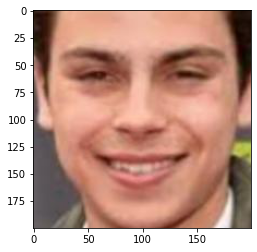

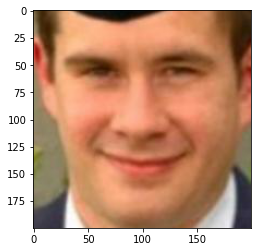

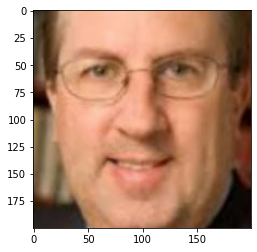

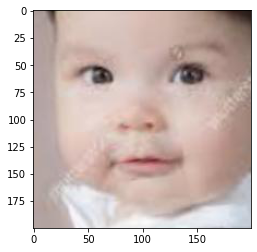

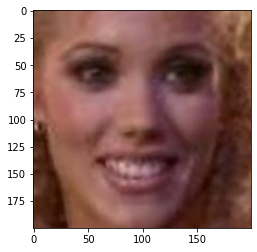

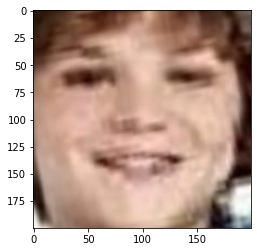

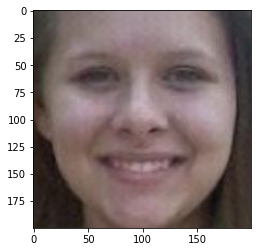

false predictions:


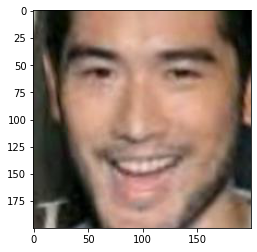

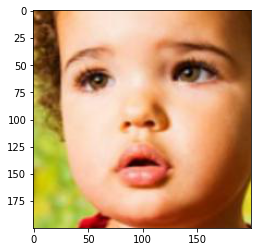

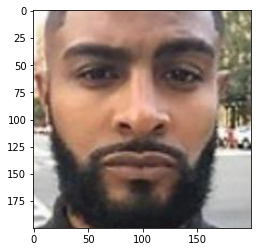

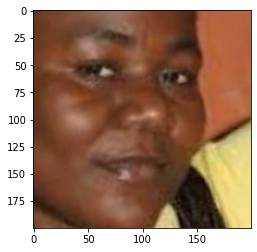

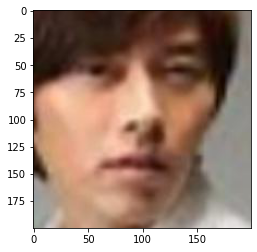

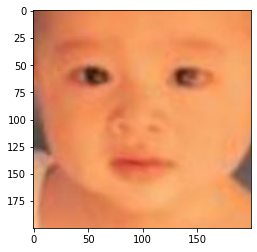

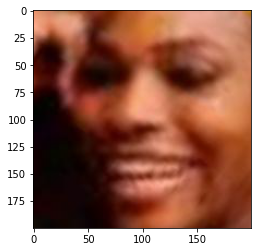

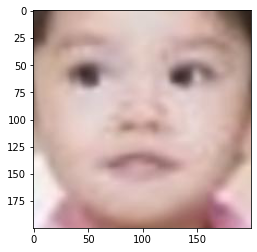

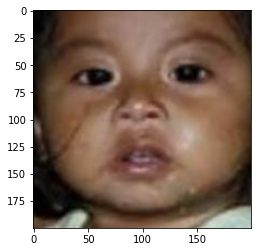

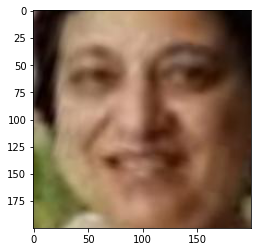

In [ ]:
print("true predictions:")
for i in range(len(right)):
    img = image.load_img(right[i])
    img = image.img_to_array(img)
    plt.imshow(img/255) 
    plt.show()
print("false predictions:")
for i in range(len(wrong)):
    img = image.load_img(wrong[i])
    img = image.img_to_array(img)
    plt.imshow(img/255) 
    plt.show()

In [29]:
import keras
train_generator, test_generator = generator(train_data, rescale = True)
inp = layers.Input(shape=(100,100,1))
flatten_inp = layers.Flatten()(inp)
Layer1_out = layers.Dense(10000, activation="relu")(flatten_inp)
Layer2_out = layers.Dense(5000, activation="relu")(Layer1_out)
Layer3_out = layers.Dense(1000, activation="relu")(Layer2_out)
Layer4_out = layers.Dense(100, activation="relu")(Layer3_out)
Layer5_out = layers.Dense(2, activation="relu")(Layer4_out)
decoded_out = layers.Dense(5, activation="softmax")(Layer5_out)

autoencoder = models.Model(inp, decoded_out)
encoder = models.Model(inp, Layer5_out)
encoded_input = keras.Input(shape=(2,))
decoder_layer = autoencoder.layers[-1]

# decoder = models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

x = model.fit(train_generator, validation_data = test_generator ,epochs=10)

Found 18964 validated image filenames belonging to 5 classes.
Found 4741 validated image filenames belonging to 5 classes.
Epoch 1/10
593/593 [==============================] - 26s 44ms/step - loss: 0.8711 - accuracy: 0.6896 - val_loss: 0.8171 - val_accuracy: 0.7081
Epoch 2/10
593/593 [==============================] - 26s 44ms/step - loss: 0.8550 - accuracy: 0.6962 - val_loss: 0.8755 - val_accuracy: 0.6731
Epoch 3/10
593/593 [==============================] - 26s 44ms/step - loss: 0.8519 - accuracy: 0.6998 - val_loss: 0.8344 - val_accuracy: 0.7053
Epoch 4/10
593/593 [==============================] - 26s 43ms/step - loss: 0.8443 - accuracy: 0.6985 - val_loss: 0.8382 - val_accuracy: 0.6996
Epoch 5/10
593/593 [==============================] - 26s 44ms/step - loss: 0.8374 - accuracy: 0.7013 - val_loss: 0.8141 - val_accuracy: 0.7093
Epoch 6/10
593/593 [==============================] - 26s 43ms/step - loss: 0.8297 - accuracy: 0.7028 - val_loss: 0.8415 - val_accuracy: 0.6992
Epoch 7/10
59

In [42]:
encoded_input


<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_9')>